In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load model directly
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from PIL import Image

processor = AutoImageProcessor.from_pretrained("nickmuchi/segformer-b4-finetuned-segments-sidewalk")
model = SegformerForSemanticSegmentation.from_pretrained("nickmuchi/segformer-b4-finetuned-segments-sidewalk")

image_path = '/Users/kevinsam/Desktop/Unif/Master/ThesisWheelchair/ThesisProject/ThesisCode/DepthSensing/images/sidewalk2.jpeg'
image = Image.open(image_path).convert("RGB")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits.squeeze().detach().cpu().numpy()
list(logits.shape)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/opt/homebrew/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


[35, 128, 128]

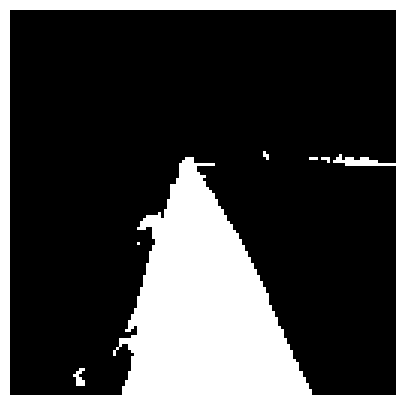

In [4]:
# Get predicted classes
predicted_classes = np.argmax(logits, axis=0)

# Get class labels from the model
class_labels = model.config.id2label

# Define a colormap for visualization
cmap = plt.cm.get_cmap('binary_r', len(class_labels))

# Filter out pixels corresponding to flat sidewalk class
flat_sidewalk_class = 2  # Assuming flat sidewalk class is labeled as 2
flat_sidewalk_mask = (predicted_classes == flat_sidewalk_class)

# Create a figure and axes for the plot
plt.figure(figsize=(10, 5))

# Display only the flat sidewalk class in the segmentation mask
masked_predicted_classes = np.where(flat_sidewalk_mask, 1, 0)  # Invert mask
plt.imshow(masked_predicted_classes, cmap='binary_r', interpolation='nearest', vmin=0, vmax=1)  # Use binary colormap for black and white
plt.axis('off')

plt.savefig('image.png', bbox_inches='tight', pad_inches=0) 
plt.show()

(127, 297)
(126, 298)
(124, 298)
(264, 301)
(262, 301)
(261, 300)
(261, 295)
(259, 295)
(258, 294)


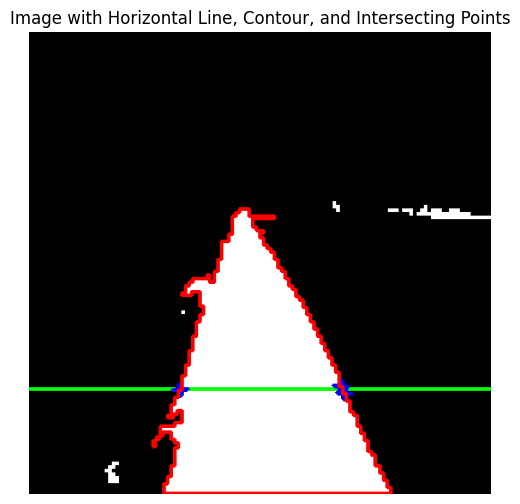

In [20]:
# Read the image
image = cv.imread('image.png')

# Convert the image to grayscale
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Apply thresholding to segment the white objects
_, thresholded_image = cv.threshold(gray_image, 240, 255, cv.THRESH_BINARY)

# Find contours in the thresholded image
contours, _ = cv.findContours(thresholded_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Find the contour with the largest area
largest_contour = max(contours, key=cv.contourArea)

# Find the moments of the largest contour
M = cv.moments(largest_contour)

# Calculate the centroid
centroid_x = int(M['m10'] / M['m00'])
centroid_y = int(M['m01'] / M['m00'])

# Draw a horizontal line across the centroid
cv.line(image, (0, centroid_y), (image.shape[1], centroid_y), (0, 255, 0), 2)

# Get contour points that intersect with the horizontal line
# Define a threshold for the distance from the line
threshold_distance = 5

# Get contour points that intersect with the horizontal line
intersecting_points = []
for point in largest_contour:
    x, y = point[0]
    if abs(y - centroid_y) < threshold_distance:
        intersecting_points.append((x, y))

# Draw the intersecting points on the image
for point in intersecting_points:
    print(point)
    cv.drawMarker(image, point, color=(255, 0, 0), markerType=cv.MARKER_CROSS, markerSize=10, thickness=2)

# Draw the contour on the image
cv.drawContours(image, [largest_contour], -1, (0, 0, 255), 2)

# Plot the image with the horizontal line, contour, and intersecting points
plt.figure(figsize=(8, 6))
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.title('Image with Horizontal Line, Contour, and Intersecting Points')
plt.axis('off')
plt.show()